In [4]:
import torch
import math
import pandas as pd
from bayes_opt.blackbox_function import BlackBoxObjective
from utils import extract_patient_meal_times

torch.manual_seed(29)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

PATIENTS = pd.read_csv('subject_profiles.csv')
NUM_MEALS = 3
patients_3 = [idx for idx in range(40) if len(extract_patient_meal_times(PATIENTS.iloc[idx])) == NUM_MEALS]
TASKS = patients_3
TRAIN_TASKS = TASKS[:10] #TASKS[:len(patients_3) - 1]
TEST_TASK = TASKS[len(patients_3) - 1]
INPUT_DIM = NUM_MEALS + 1

In [5]:
BOUNDS = torch.cat([torch.zeros((1, INPUT_DIM), dtype=dtype),
                      torch.ones((1, INPUT_DIM), dtype=dtype)], dim=0)
obj = BlackBoxObjective(num_meals=NUM_MEALS)
def f(X, shift=TASKS[0], include_BMs=False):
    """
    Torch-compatible objective function for the target_task
    """
    if include_BMs: 
        f_X, BMs = obj.f(X=X, shift=shift, include_BMs=include_BMs)
        return f_X, BMs
    f_X = obj.f(X=X, shift=shift, include_BMs=include_BMs)
    return f_X


In [6]:
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import normalize, unnormalize

noise_std = 0.001

# Sample data for each base task
data_by_task = {}
for task in TRAIN_TASKS:
    num_training_points = 20
    # draw points from a sobol sequence
    raw_x = draw_sobol_samples(bounds=BOUNDS, n=num_training_points, q=1, seed=task+5397923).squeeze(1)
    # get observed values
    f_x = f(raw_x, task)
    train_y = f_x + noise_std*torch.randn_like(f_x)
    train_yvar = torch.full_like(train_y, noise_std**2)
    # store training data
    data_by_task[task] = {
        # scale x to [0, 1]
        'train_x': normalize(raw_x, bounds=BOUNDS),
        'train_y': train_y,
        'train_yvar': train_yvar,
    }         

In [7]:
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import FixedNoiseGP
from botorch.fit import fit_gpytorch_model


def get_fitted_model(train_X, train_Y, train_Yvar, state_dict=None):
    """
    Get a single task GP. The model will be fit unless a state_dict with model 
        hyperparameters is provided.
    """
    Y_mean = train_Y.mean(dim=-2, keepdim=True)
    Y_std = train_Y.std(dim=-2, keepdim=True)
    model = FixedNoiseGP(train_X, (train_Y - Y_mean)/Y_std, train_Yvar)
    model.Y_mean = Y_mean
    model.Y_std = Y_std
    if state_dict is None:
        mll = ExactMarginalLogLikelihood(model.likelihood, model).to(train_X)
        fit_gpytorch_model(mll)
    else:
        model.load_state_dict(state_dict)
    return model

In [9]:
# Fit base model
base_model_list = []
for task in TRAIN_TASKS:
    print(f"Fitting base model {task}")
    model = get_fitted_model(
        data_by_task[task]['train_x'], 
        data_by_task[task]['train_y'], 
        data_by_task[task]['train_yvar'],
    )
    base_model_list.append(model) 

Fitting base model 0
Fitting base model 1
Fitting base model 2
Fitting base model 3
Fitting base model 4
Fitting base model 5
Fitting base model 7
Fitting base model 8
Fitting base model 10
Fitting base model 11


In [10]:
def roll_col(X, shift):  
    """
    Rotate columns to right by shift.
    """
    return torch.cat((X[..., -shift:], X[..., :-shift]), dim=-1)

In [11]:
def compute_ranking_loss(f_samps, target_y):
    """
    Compute ranking loss for each sample from the posterior over target points.
    
    Args:
        f_samps: `n_samples x (n) x n`-dim tensor of samples
        target_y: `n x 1`-dim tensor of targets
    Returns:
        Tensor: `n_samples`-dim tensor containing the ranking loss across each sample
    """
    n = target_y.shape[0]
    if f_samps.ndim == 3:
        # Compute ranking loss for target model
        # take cartesian product of target_y
        cartesian_y = torch.cartesian_prod(
            target_y.squeeze(-1), 
            target_y.squeeze(-1),
        ).view(n, n, 2)
        # the diagonal of f_samps are the out-of-sample predictions
        # for each LOO model, compare the out of sample predictions to each in-sample prediction
        rank_loss = ((f_samps.diagonal(dim1=1, dim2=2).unsqueeze(-1) < f_samps) ^ (cartesian_y[..., 0] < cartesian_y[..., 1])).sum(dim=-1).sum(dim=-1)
    else:
        rank_loss = torch.zeros(f_samps.shape[0], dtype=torch.long, device=target_y.device)
        y_stack = target_y.squeeze(-1).expand(f_samps.shape)
        for i in range(1,target_y.shape[0]):
            rank_loss += ((roll_col(f_samps, i) < f_samps) ^ (roll_col(y_stack, i) < y_stack)).sum(dim=-1) 
    return rank_loss

In [12]:
def get_target_model_loocv_sample_preds(train_x, train_y, train_yvar, target_model, num_samples):
    """
    Create a batch-mode LOOCV GP and draw a joint sample across all points from the target task.
    
    Args:
        train_x: `n x d` tensor of training points
        train_y: `n x 1` tensor of training targets
        target_model: fitted target model
        num_samples: number of mc samples to draw
    
    Return: `num_samples x n x n`-dim tensor of samples, where dim=1 represents the `n` LOO models,
        and dim=2 represents the `n` training points.
    """
    batch_size = len(train_x)
    masks = torch.eye(len(train_x), dtype=torch.uint8, device=device).bool()
    train_x_cv = torch.stack([train_x[~m] for m in masks])
    train_y_cv = torch.stack([train_y[~m] for m in masks])
    train_yvar_cv = torch.stack([train_yvar[~m] for m in masks])
    state_dict = target_model.state_dict()
    # expand to batch size of batch_mode LOOCV model
    state_dict_expanded = {name: t.expand(batch_size, *[-1 for _ in range(t.ndim)]) for name, t in state_dict.items()}
    model = get_fitted_model(train_x_cv, train_y_cv, train_yvar_cv, state_dict=state_dict_expanded)
    with torch.no_grad():
        posterior = model.posterior(train_x)
        # Since we have a batch mode gp and model.posterior always returns an output dimension,
        # the output from `posterior.sample()` here `num_samples x n x n x 1`, so let's squeeze
        # the last dimension.
        sampler = SobolQMCNormalSampler(num_samples=num_samples)
        return sampler(posterior).squeeze(-1)

In [13]:
def compute_rank_weights(train_x,train_y, base_models, target_model, num_samples):
    """
    Compute ranking weights for each base model and the target model (using 
        LOOCV for the target model). Note: This implementation does not currently 
        address weight dilution, since we only have a small number of base models.
    
    Args:
        train_x: `n x d` tensor of training points (for target task)
        train_y: `n` tensor of training targets (for target task)
        base_models: list of base models
        target_model: target model
        num_samples: number of mc samples
    
    Returns:
        Tensor: `n_t`-dim tensor with the ranking weight for each model
    """
    ranking_losses = []
    # compute ranking loss for each base model
    for task in range(len(base_models)):
        model = base_models[task]
        # compute posterior over training points for target task
        posterior = model.posterior(train_x)
        sampler = SobolQMCNormalSampler(num_samples=num_samples)
        base_f_samps = sampler(posterior).squeeze(-1).squeeze(-1)
        # compute and save ranking loss
        ranking_losses.append(compute_ranking_loss(base_f_samps, train_y))
    # compute ranking loss for target model using LOOCV
    # f_samps
    target_f_samps = get_target_model_loocv_sample_preds(train_x, train_y, train_yvar, target_model, num_samples)
    ranking_losses.append(compute_ranking_loss(target_f_samps, train_y))
    ranking_loss_tensor = torch.stack(ranking_losses)
    # compute best model (minimum ranking loss) for each sample
    best_models = torch.argmin(ranking_loss_tensor, dim=0)
    # compute proportion of samples for which each model is best
    rank_weights = best_models.bincount(minlength=len(ranking_losses)).type_as(train_x)/num_samples
    return rank_weights

In [14]:
from botorch.models.gpytorch import GPyTorchModel
from gpytorch.models import GP
from gpytorch.distributions import MultivariateNormal
from gpytorch.lazy import PsdSumLazyTensor
from gpytorch.likelihoods import LikelihoodList
from torch.nn import ModuleList


class RGPE(GP, GPyTorchModel):
    """
    Rank-weighted GP ensemble. Note: this class inherits from GPyTorchModel which provides an 
        interface for GPyTorch models in botorch.
    """
    
    _num_outputs = 1  # metadata for botorch
    
    def __init__(self, models, weights):
        super().__init__()
        self.models = ModuleList(models)
        for m in models:
            if not hasattr(m, "likelihood"):
                raise ValueError(
                    "RGPE currently only supports models that have a likelihood (e.g. ExactGPs)"
                )
        self.likelihood = LikelihoodList(*[m.likelihood for m in models])
        self.weights = weights
        self.to(weights)
        
    def forward(self, x):
        weighted_means = []
        weighted_covars = []
        # filter model with zero weights
        # weights on covariance matrices are weight**2
        non_zero_weight_indices = (self.weights**2 > 0).nonzero()
        non_zero_weights = self.weights[non_zero_weight_indices]
        # re-normalize
        non_zero_weights /= non_zero_weights.sum()
        
        for non_zero_weight_idx in range(non_zero_weight_indices.shape[0]):
            raw_idx = non_zero_weight_indices[non_zero_weight_idx].item()
            model = self.models[raw_idx]
            posterior = model.posterior(x)
            # unstandardize predictions
            posterior_mean = posterior.mean.squeeze(-1)*model.Y_std + model.Y_mean
            posterior_cov = posterior.mvn.lazy_covariance_matrix * model.Y_std.pow(2)
            # apply weight
            weight = non_zero_weights[non_zero_weight_idx]
            weighted_means.append(weight * posterior_mean)
            weighted_covars.append(posterior_cov * weight**2)
        # set mean and covariance to be the rank-weighted sum the means and covariances of the
        # base models and target model
        mean_x = torch.stack(weighted_means).sum(dim=0)
        covar_x = PsdSumLazyTensor(*weighted_covars)
        return MultivariateNormal(mean_x, covar_x)

In [15]:
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.optim.optimize import optimize_acqf

# suppress GPyTorch warnings about adding jitter
import warnings
warnings.filterwarnings("ignore", "^.*jitter.*", category=RuntimeWarning)

    
best_rgpe_all = []
best_argmax_rgpe_all = []
best_random_all = []
best_vanilla_nei_all = []
N_BATCH = 5
NUM_POSTERIOR_SAMPLES = 256
RANDOM_INITIALIZATION_SIZE = 10
N_TRIALS = 1
MC_SAMPLES = 512
N_RESTART_CANDIDATES = 512
N_RESTARTS = 10
Q_BATCH_SIZE = 1

# Average over multiple trials
for trial in range(N_TRIALS):
    print(f"Trial {trial + 1} of {N_TRIALS}")
    best_BMs = []
    best_rgpe = []
    best_random = [] 
    best_vanilla_nei = []
    # Initial random observations
    raw_x = draw_sobol_samples(bounds=BOUNDS, n=RANDOM_INITIALIZATION_SIZE, q=1, seed=trial).squeeze(1)    
    train_x = normalize(raw_x, bounds=BOUNDS)
    train_y_noiseless = f(raw_x, shift=TEST_TASK) 
    train_y = train_y_noiseless + noise_std*torch.randn_like(train_y_noiseless)
    train_yvar = torch.full_like(train_y, noise_std**2)
    # keep track of the best observed point at each iteration
    best_value = train_y.max().item()
    best_rgpe.append(best_value)
    best_random.append(best_value)
    vanilla_nei_best_value = best_value
    best_vanilla_nei.append(vanilla_nei_best_value)

    # Run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(N_BATCH): 
        target_model = get_fitted_model(train_x, train_y, train_yvar)
        model_list = base_model_list + [target_model]
        rank_weights = compute_rank_weights(
            train_x, 
            train_y, 
            base_model_list, 
            target_model, 
            NUM_POSTERIOR_SAMPLES,
        )
       
        # create model and acquisition function
        rgpe_model = RGPE(model_list, rank_weights)
        sampler_qnei = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
        qNEI = qNoisyExpectedImprovement(
            model=rgpe_model, 
            X_baseline=train_x,
            sampler=sampler_qnei,
        )
        
        # optimize
        candidate, _ = optimize_acqf(
            acq_function=qNEI,
            bounds=BOUNDS,
            q=Q_BATCH_SIZE,
            num_restarts=N_RESTARTS,
            raw_samples=N_RESTART_CANDIDATES,
        )

        # fetch the new values 
        new_x = candidate.detach()
        new_y_noiseless = f(unnormalize(new_x, bounds=BOUNDS), shift=TEST_TASK)
        new_y = new_y_noiseless + noise_std*torch.randn_like(new_y_noiseless)
        new_yvar = torch.full_like(new_y, noise_std**2)

        # update training points
        train_x = torch.cat((train_x, new_x))
        train_y = torch.cat((train_y, new_y))
        train_yvar = torch.cat((train_yvar, new_yvar))
        random_candidate = torch.rand((1, NUM_MEALS + 1), dtype=dtype, device=device)
        next_random_noiseless = f(unnormalize(random_candidate, bounds=BOUNDS), shift=TEST_TASK)
        next_random = next_random_noiseless + noise_std * torch.randn_like(next_random_noiseless)
        next_random_best = next_random.max().item()
        best_random.append(max(best_random[-1], next_random_best))

        # get the new best observed value
        best_value = train_y.max().item()
        best_idx = torch.argmax(train_y).item()
        best_candidate = train_x[best_idx].view(1, -1)
        _, best_BM = f(unnormalize(best_candidate, bounds=BOUNDS),
                         shift=TEST_TASK,
                         include_BMs=True)
        
        print(best_idx, best_BM, best_value)
        best_rgpe.append(best_value)
        best_BMs.append(best_BM)
        
    best_rgpe_all.append(best_rgpe)
    best_argmax_rgpe_all.append(best_BMs)

Trial 1 of 1
10 [array([[140.        , 251.        , 400.        , 725.        ],
       [  5.73768157,   4.86401641,   3.38410573,   3.47437154]])] -16.77032906320135
11 [array([[140.        , 251.        , 400.        , 725.        ],
       [  5.67599614,   5.52736752,   4.62616401,   2.38960295]])] -15.104776553363617
11 [array([[140.        , 251.        , 400.        , 725.        ],
       [  5.67599614,   5.52736752,   4.62616401,   2.38960295]])] -15.104776553363617
13 [array([[140.        , 251.        , 400.        , 725.        ],
       [  5.71239497,   6.12798231,   5.04671762,   3.68597619]])] -13.02074787955188
13 [array([[140.        , 251.        , 400.        , 725.        ],
       [  5.71239497,   6.12798231,   5.04671762,   3.68597619]])] -13.02074787955188


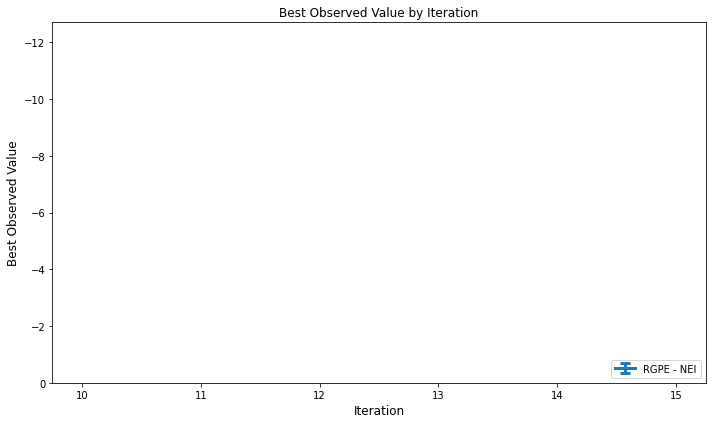

In [16]:
import numpy as np
import matplotlib.pyplot as plt

best_rgpe_all = np.array(best_rgpe_all)
best_random_all = np.array(best_random_all)
best_vanilla_nei_all = np.array(best_vanilla_nei_all)

x = range(RANDOM_INITIALIZATION_SIZE, RANDOM_INITIALIZATION_SIZE + N_BATCH + 1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# Plot RGPE - NEI
ax.errorbar(
    x, 
    best_rgpe_all.mean(axis=0), 
    yerr=1.96 * best_rgpe_all.std(axis=0) / math.sqrt(N_TRIALS), 
    label="RGPE - NEI", 
    linewidth=3, 
    capsize=5,
    capthick=3,
)
ax.set_ylim(bottom=0)
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Best Observed Value', fontsize=12)
ax.set_title('Best Observed Value by Iteration', fontsize=12)
ax.legend(loc="lower right", fontsize=10)
plt.tight_layout()